# Notebook to demonstrate Independent Randomization for CNN MNIST

In this notebook, we will take a trained CNN (on MNIST) and generate saliency maps of various kinds from this CNN and perform the independent layer randomization as done in the paper "Sanity Checks for Saliency Maps".

**Before running this notebook** make sure that you have installed all the necessary dependencies. See the requirements.txt file in the top level folder for this. This notebook can be easily adapted to Fashion MNIST.

Note that this notebook is mostly a copy paste of the cascading version, but left to be self-contained.

In [1]:
# take care of imports
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # you can turn this on if you'd prefer to do this on a GPU
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
import seaborn as sns
import saliency
import pickle

from tensorflow import keras 
from tensorflow.keras.datasets import mnist, fashion_mnist
from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr # this is needed to compute the spearman rank correlation.
import pandas as pd

# some plotting defaults
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

2023-12-10 23:51:25.999818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 23:51:27.229968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.core.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.core.VisualizeImageDiverging(img)
    return img

def get_nist_data(mst=True,
                  validation=True,
                  norm_divisor=255.0,
                  label_to_categorical=True,
                  num_classes=10):
    if mst:
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    if norm_divisor:
        x_train = x_train/norm_divisor
        x_test = x_test/norm_divisor
    if validation:
        x_valid, x_train = x_train[:5000], x_train[5000:]
        y_valid, y_train = y_train[:5000], y_train[5000:]
    if label_to_categorical:
        y_test = keras.utils.to_categorical(y_test, num_classes)
        y_train = keras.utils.to_categorical(y_train, num_classes)
    if validation:
        y_valid = keras.utils.to_categorical(y_valid, num_classes)
    return (x_train, x_valid, x_test), (y_train, y_valid, y_test)

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

In [3]:
def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Returns functions to compute saliency masks for methods in saliency package.
    Args:
        model_graph: tf graph of the model for which saliency is to be computed.
        model_session: tf session in which the trained model has been loaded.
        logit_tensor: tensor corresponding to the logit output of the network.
        input_tensor: tensor coressponding to the input data.
        gradcam: Boolean to indicate whether to compute gradcam saliency maps.
        conv_layer_gradcam: tensor corresponding to activations from a conv layer,
                            from the trained model. Authors recommend last layer.
    
    Returns:
        saliency_constructor: dictionary where key is name of method, and value is 
                              function to each saliency method.
        
        neuron_selector: tensor to indicate which specific output to explain.
    """
    assert (type(tf.Graph()) == type(model_graph)), ("Model graph should be of type"
                                                     "{}".format(type(tf.Graph())))
    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam is be provided.")
    
    #
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector] # this is the neuron to explain.
    
    gradient_saliency = saliency.tf1.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.tf1.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.tf1.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    
    if gradcam:
        gradcam = saliency.tf1.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
    
    return saliency_constructor, neuron_selector




def load_graph_and_randomize_layer(checkptpath,
                                   metapath,
                                   logitop="logits",
                                   inputop="x",
                                   gcamop="hidden2_hconv_act",
                                   randomize=False,
                                   layertorandomize=[]):
    tf.reset_default_graph()
    new_session = tf.Session()
    saver = tf.train.import_meta_graph(metapath)
    saver.restore(new_session, checkptpath)
    current_graph = tf.get_default_graph()
    y_logits_op = tf.get_collection(logitop)[0]
    input_op = tf.get_collection(inputop)[0]
    h2convact = None
    if gcamop:
        h2convact = tf.get_collection(gcamop)[0]
    trainable_ops = tf.trainable_variables()
    list_of_ops_to_randomize = []
    randparamlist = None

    if randomize:
        for layer in layertorandomize:
            for op in trainable_ops:
                if layer in op.name:
                    list_of_ops_to_randomize.append(op)
        with current_graph.as_default():
            to_ini = tf.initialize_variables(list_of_ops_to_randomize)
            _ = new_session.run(to_ini)
            randparamlist = new_session.run(trainable_ops)
    
    return (current_graph, new_session, y_logits_op, input_op, h2convact, trainable_ops, randparamlist)

# Load Pretrained model and make a few predictions

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

modelpath = '../models/cnn_mnist/' # update this to the relevant path for your model.

# this will check that the files are in the desired paths
if not os.path.exists(modelpath+"final_cnn_model_mnist.meta"):
    raise ValueError("final_cnn_model_mnist.meta not in the path specified.")
    
if not os.path.exists(modelpath+"final_cnn_model_mnist.index"):
    raise ValueError("final_cnn_model_mnist.index not in the path specified.")


# path to metapath and checkpoint path
METAPATH = (modelpath + "final_cnn_model_mnist.meta")
CHECKPOINTPATH = (modelpath + "final_cnn_model_mnist")

# op names to load
gradcamtensorname = "hidden2_hconv_act" # this is the name of the tensor in the graph for gradcam.
logitop = "logits"
inputop = "x"

tf.reset_default_graph()
new_session = tf.Session()
saver = tf.train.import_meta_graph(METAPATH)
saver.restore(new_session, CHECKPOINTPATH)
current_graph = tf.get_default_graph()
y_logits_op = tf.get_collection(logitop)[0]
input_op = tf.get_collection(inputop)[0]
h2convact = tf.get_collection(gradcamtensorname)[0]
trainable_ops = tf.trainable_variables()

Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist


2023-12-10 23:51:29.598219: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-12-10 23:51:29.695836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


x_test shape:  (10, 28, 28)
y_test shape:  (10, 10)


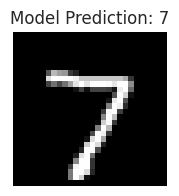

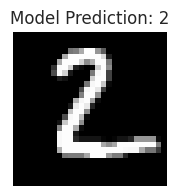

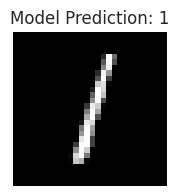

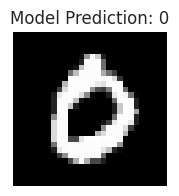

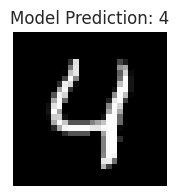

In [5]:
xtuple, ytuple = get_nist_data(mst=True,
                  validation=True,
                  norm_divisor=255.0,
                  label_to_categorical=True,
                  num_classes=10)

_, _, x_test = xtuple
_, _, y_test = ytuple

# let's use the first 10 as demo
demo_sample_number = 10
demobatch = x_test[:demo_sample_number]
demobatchlabels = y_test[:demo_sample_number]

print("x_test shape: ", demobatch.shape)
print("y_test shape: ", demobatchlabels.shape)

# we'll predict on this first 10 images
logits =  new_session.run([y_logits_op], feed_dict={input_op: demobatch})[0]
predictions = logits.argmax(axis=1)

for i in range(5):
    plot_single_img(demobatch[i],
                    fig_size=(2,2),
                    title="Model Prediction: "+str(predictions[i]))

# Compute masks for a non-randomized model

In [6]:
# setup constructor and methods
saliency_dict, n_selector = get_saliency_constructors(new_session.graph,
                                                      new_session,
                                                      y_logits_op[0],
                                                      input_op,
                                                      gradcam=True,
                                                      conv_layer_gradcam=h2convact)

saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                    'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                    'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                    'Integrated\nGradients': saliency_dict['ig'].GetMask,
                    'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                    'GradCAM': saliency_dict['gc'].GetMask}

list_of_masks = [] # save aggregate masks here.
for i, current_image in enumerate(demobatch):
    print("On image {}".format(i))
    baseline = np.zeros(current_image.shape)
    imglogits = new_session.run([y_logits_op],
                                    feed_dict={input_op: np.expand_dims(current_image, 0)})[0]
    
    prediction_class = imglogits.argmax() # this the output to explain.
    gen_feed_dict = {n_selector: prediction_class}
    
    # set up params for each saliency method
    saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                       'SmoothGrad': {"feed_dict": gen_feed_dict,
                                      "stdev_spread":0.15,
                                      "nsamples":50,
                                      "magnitude":False},
                       'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                       'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                 "x_steps":50,
                                                 "x_baseline":baseline},
                       'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                          "x_steps":50,
                                          "stdev_spread": 0.15,
                                          "x_baseline":baseline,
                                          "magnitude":False},
                       'GradCAM':{"feed_dict": gen_feed_dict,
                                  "three_dims": False}
                      }    
    
    output_masks = {}
    for key in saliency_methods:
        # print("On {}".format(key))
        params = saliency_params[key]
        output_masks[key] = saliency_methods[key](current_image,**params)
            
    # compute some other methods
    # input-gradient and guided-gradcam
    output_masks["Input-Grad"] = output_masks['Gradient']*current_image
    output_masks["GBP-GC"] = output_masks['Guided\nBackProp']*output_masks['GradCAM']
    list_of_masks.append(output_masks)

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On image 0


On image 1
On image 2
On image 3
On image 4
On image 5
On image 6
On image 7
On image 8
On image 9


In [7]:
# We are now doing normalization of the different attributions
# normalize by absolute values
list_of_masks_abs_norm = []

# normalize but keep the signs
list_of_masks_no_abs_norm = []

for i, img_dict in enumerate(list_of_masks):
    new_dict_abs_norm = {}
    new_dict_no_abs_norm = {}
    for key in img_dict:
        mask = img_dict[key]
        mask_abs_norm = abs_grayscale_norm(mask)
        mask_no_abs_norm = diverging_norm(mask)
        new_dict_abs_norm[key] = mask_abs_norm
        new_dict_no_abs_norm[key] = mask_no_abs_norm
        
    list_of_masks_abs_norm.append(new_dict_abs_norm)
    list_of_masks_no_abs_norm.append(new_dict_no_abs_norm)
    
# combine all the images to be plotted into one long list
# format is [(input, mask1, mask2, etc)]
mask_order = ["Gradient", "SmoothGrad", "Guided\nBackProp",\
              "Integrated\nGradients", "Input-Grad", "IG\nSmoothGrad", "GradCAM", "GBP-GC"]
master_mask_list_abs_norm = []
master_mask_list_no_abs_norm = []
for i, (img_dict_abs_norm, img_dict_no_abs_norm) in enumerate(zip(list_of_masks_abs_norm,
                                                                  list_of_masks_no_abs_norm)):
    # first append original image
    og_img = demobatch[i]
    master_mask_list_abs_norm.append(og_img)
    master_mask_list_no_abs_norm.append(og_img)
    
    # loop through dicts to append each mask type
    for mask_type in mask_order:
        master_mask_list_abs_norm.append(img_dict_abs_norm[mask_type])
        master_mask_list_no_abs_norm.append(img_dict_no_abs_norm[mask_type])

# Perform independent layer randomization

In [8]:
layer_names = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]
master_independent_randomization_dictionary = {} # key will be layer name.
for layer_name in layer_names:
    print("On layer {}".format(layer_name))
    # reintialize the required layer
    graphinfo = load_graph_and_randomize_layer(
                                   CHECKPOINTPATH,
                                   METAPATH,
                                   logitop="logits",
                                   inputop="x",
                                   gcamop="hidden2_hconv_act",
                                   randomize=True,
                                   layertorandomize=[layer_name])
    current_graph = graphinfo[0]
    new_session = graphinfo[1]
    y_logits_op = graphinfo[2]
    input_op = graphinfo[3]
    h2convact = graphinfo[4]
    list_of_ops_training = graphinfo[5]
    randparamlist = graphinfo[6]
    
    # set up saliency dict and n_selector.
    saliency_dict, n_selector = get_saliency_constructors(current_graph,
                                                          new_session,
                                                          y_logits_op[0],
                                                          input_op,
                                                          gradcam=True,
                                                          conv_layer_gradcam=h2convact)
    
    saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                        'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                        'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                        'Integrated\nGradients': saliency_dict['ig'].GetMask,
                        'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                        'GradCAM': saliency_dict['gc'].GetMask}
    
    list_of_random_mask_per_layer = []
    for i, current_image in enumerate(demobatch):
        baseline = np.zeros(current_image.shape)
        imglogits = new_session.run([y_logits_op], feed_dict={input_op: np.expand_dims(current_image, 0)})[0]

        prediction_class = imglogits.argmax() # this the output to explain.
        gen_feed_dict = {n_selector: prediction_class}

        # set up params for each saliency method
        saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                           'SmoothGrad': {"feed_dict": gen_feed_dict,
                                          "stdev_spread":0.15,
                                          "nsamples":15,
                                          "magnitude":False},
                           'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                           'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                     "x_steps":50,
                                                     "x_baseline":baseline},
                           'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                              "x_steps":50,
                                              "stdev_spread": 0.15,
                                              "x_baseline":baseline,
                                              "magnitude":False},
                           'GradCAM':{"feed_dict": gen_feed_dict,
                                      "three_dims": False}
                          }    

        output_masks = {}
        for key in saliency_methods:
            params = saliency_params[key]
            output_masks[key] = saliency_methods[key](current_image,**params)

        # compute some other methods
        # input-gradient and guided-gradcam
        output_masks["Input-Grad"] = output_masks['Gradient']*current_image
        output_masks["GBP-GC"] = output_masks['Guided\nBackProp']*output_masks['GradCAM']
        list_of_random_mask_per_layer.append(output_masks)
        
    # now add the list of random masks to the dictionary
    master_independent_randomization_dictionary[layer_name] = list_of_random_mask_per_layer

On layer softmax_linear
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
Instructions for updating:
Use `tf.variables_initializer` instead.


2023-12-10 23:51:57.837103: W tensorflow/c/c_api.cc:304] Operation '{name:'softmax_linear/Variable_1/Assign' id:69 op device:{requested: '', assigned: ''} def:{{{node softmax_linear/Variable_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@softmax_linear/Variable_1"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](softmax_linear/Variable_1, softmax_linear/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


On layer fc1
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist


2023-12-10 23:52:23.750009: W tensorflow/c/c_api.cc:304] Operation '{name:'fc1/Variable_1/Assign' id:51 op device:{requested: '', assigned: ''} def:{{{node fc1/Variable_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@fc1/Variable_1"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](fc1/Variable_1, fc1/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On layer hidden2
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist


2023-12-10 23:52:59.385749: W tensorflow/c/c_api.cc:304] Operation '{name:'hidden2/Variable_1/Assign' id:34 op device:{requested: '', assigned: ''} def:{{{node hidden2/Variable_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@hidden2/Variable_1"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](hidden2/Variable_1, hidden2/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
On layer hidden1
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist


2023-12-10 23:53:25.153072: W tensorflow/c/c_api.cc:304] Operation '{name:'hidden1/Variable_1/Assign' id:17 op device:{requested: '', assigned: ''} def:{{{node hidden1/Variable_1/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@hidden1/Variable_1"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](hidden1/Variable_1, hidden1/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


# Assemble Masks for easy plotting

In [9]:
master_independent_randomization_dictionary_abs_norm = {}
master_independent_randomization_dictionary_no_abs_norm = {}

for layer in master_independent_randomization_dictionary:
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    for i, mask_dict in enumerate(master_independent_randomization_dictionary[layer]):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
    master_independent_randomization_dictionary_abs_norm[layer] = mask_list_abs_norm
    master_independent_randomization_dictionary_no_abs_norm[layer] = mask_list_no_abs_norm
    
for key in master_independent_randomization_dictionary:
    assert len(master_independent_randomization_dictionary[key])==len(master_independent_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_independent_randomization_dictionary[key]):
        assert len(item)==len(master_independent_randomization_dictionary_no_abs_norm[key][i])
for key in master_independent_randomization_dictionary:
    assert len(master_independent_randomization_dictionary[key])==len(master_independent_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_independent_randomization_dictionary[key]):
        assert len(item)==len(master_independent_randomization_dictionary_abs_norm[key][i])

# Positive Relevance Plotting

In [10]:
independent_master_plotting_list_abs_norm = []
independent_master_plotting_list_no_abs_norm = []

index_to_input_to_plot = 0 # this must be less than the len of demo_batch
assert index_to_input_to_plot < demobatch.shape[0]


# Order that we want to show the masks in.
mask_order = ["Gradient", "SmoothGrad", "Guided\nBackProp",\
              "Integrated\nGradients", "Input-Grad", "IG\nSmoothGrad", "GradCAM", "GBP-GC"]
layer_order = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]

for method in mask_order:
    # first insert normal saliency method
    normal_mask_abs_norm = list_of_masks_abs_norm[index_to_input_to_plot][method]
    normal_mask_no_abs_norm = list_of_masks_no_abs_norm[index_to_input_to_plot][method]
    independent_master_plotting_list_abs_norm.append(normal_mask_abs_norm)
    independent_master_plotting_list_no_abs_norm.append(normal_mask_no_abs_norm)
    for layer in layer_order:
        mask_abs_norm =  master_independent_randomization_dictionary_abs_norm[layer][index_to_input_to_plot][method]
        independent_master_plotting_list_abs_norm.append(mask_abs_norm)
        
        mask_no_abs_norm =  master_independent_randomization_dictionary_no_abs_norm[layer][index_to_input_to_plot][method]
        independent_master_plotting_list_no_abs_norm.append(mask_no_abs_norm)

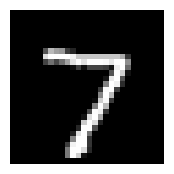

AttributeError: 'Axes' object has no attribute 'is_first_col'

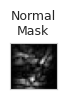

In [11]:
methods = len(mask_order)
layer_number = 4
ncols = layer_number + 1
nrows = methods

    
plot_single_img(demobatch[index_to_input_to_plot],
                fig_size=(2,2))
plt.show()
    
fig = plt.figure(figsize=(3,6))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='gray'
count = 0
titles = ["Gradient", "SG", "GBP",\
          "IG", "Ipt-Grad", "IG-SG", "GradCAM", "GBP-GC"]
new_layer_names = ['Normal\nMask', 'smax', 'fc1', 'h2', 'h1']
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(independent_master_plotting_list_abs_norm[count],
                  vmin=0.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
            
        # add labels
        if count < 5:
            ax.set_title(new_layer_names[count], fontsize=9)
            
        # increment count
        count +=1
            
        if j == 0:
            ax.set_ylabel(titles[i], fontsize=9,rotation='horizontal', ha='right')
        
plt.show()

# Show Positive and Negative Relevance

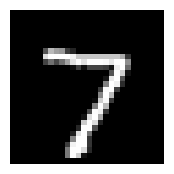

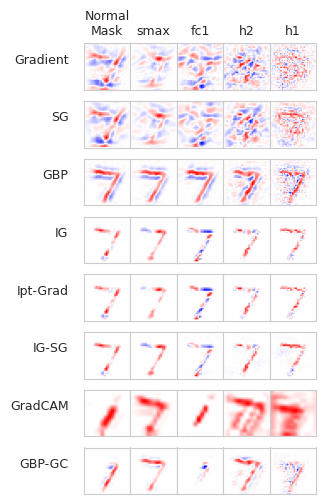

In [ ]:
plot_single_img(demobatch[index_to_input_to_plot],
                fig_size=(2,2))
plt.show()
    
fig = plt.figure(figsize=(3,6))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        ax.imshow(independent_master_plotting_list_no_abs_norm[count],
                  vmin=-1.0,
                  vmax=1.0,
                  cmap=cmap)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
            
        # add labels
        if count < 5:
            ax.set_title(new_layer_names[count], fontsize=9)
            
        # increment count
        count +=1
            
        if j == 0:
            ax.set_ylabel(titles[i], fontsize=9,rotation='horizontal', ha='right')
plt.show()

# Compute Rank Correlation

In [ ]:
layer_order = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]
methods_list = list(master_independent_randomization_dictionary_abs_norm['softmax_linear'][0].keys())

# dictionary to save all of the metrics.
rank_correlation_dictionary_abs_norm = {}
rank_correlation_dictionary_no_abs_norm = {}

# initialize the dictionaries appropriately.
for layer in layer_order:
    rank_correlation_dictionary_abs_norm[layer] = {}
    rank_correlation_dictionary_no_abs_norm[layer] = {}
    for method in methods_list:
        rank_correlation_dictionary_abs_norm[layer][method] = []
        rank_correlation_dictionary_no_abs_norm[layer][method] = []

        
for layer in master_independent_randomization_dictionary_abs_norm:
    for i, mask_dict in enumerate(master_independent_randomization_dictionary_abs_norm[layer]):
        for method in methods_list:
            normal_mask_abs_norm = list_of_masks_abs_norm[i][method]
            normal_mask_no_abs_norm = list_of_masks_no_abs_norm[i][method]
            
            rand_mask_abs_norm = mask_dict[method]
            rand_mask_no_abs_norm =\
                master_independent_randomization_dictionary_no_abs_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            # collate all the values into their respective dictionaries.
            rank_correlation_dictionary_abs_norm[layer][method].append(rk_abs)
            rank_correlation_dictionary_no_abs_norm[layer][method].append(rk_no_abs)

In [ ]:
# aggregate into plotting dictionary
rk_plotting_dictionary_abs_value = {}
layer_names = list(rank_correlation_dictionary_abs_norm.keys())
method_names = list(rank_correlation_dictionary_abs_norm[layer_names[0]].keys())
for method in methods_list:
    rk_plotting_dictionary_abs_value[method] = []
rk_plotting_dictionary_abs_value['layername'] = []
for layer in rank_correlation_dictionary_abs_norm:
    layername_list = [layer]*len(rank_correlation_dictionary_abs_norm[layer][method_names[0]])
    rk_plotting_dictionary_abs_value['layername'].extend(layername_list)
    for i, method in enumerate(rank_correlation_dictionary_abs_norm[layer]):
        rk_plotting_dictionary_abs_value[method].extend(rank_correlation_dictionary_abs_norm[layer][method])

In [ ]:
df = pd.DataFrame(rk_plotting_dictionary_abs_value)
df.head()

,Gradient,SmoothGrad,Guided\nBackProp,Integrated\nGradients,IG\nSmoothGrad,GradCAM,Input-Grad,GBP-GC,layername
0,0.570434,0.475314,0.835811,0.996199,0.576822,0.479415,0.995781,0.559630,softmax_linear
1,0.495477,0.504480,0.923056,0.988407,0.579452,0.120999,0.988979,0.358737,softmax_linear
2,0.765839,0.525214,0.888177,0.999410,0.549940,0.833515,0.998658,0.823254,softmax_linear
3,0.581027,0.619612,0.936236,0.986804,0.745826,0.571861,0.984969,0.521417,softmax_linear
4,0.582790,0.542309,0.893799,0.995474,0.575732,0.655424,0.994863,0.708792,softmax_linear


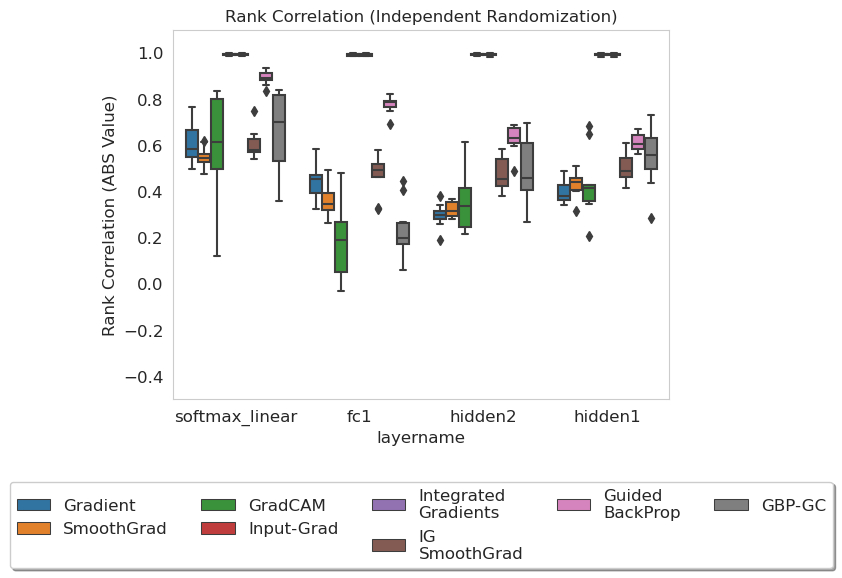

In [ ]:
first_methods = ['Gradient', 'SmoothGrad', 'GradCAM', 'Input-Grad', 'Integrated\nGradients', 'IG\nSmoothGrad',
                 'Guided\nBackProp', 'GBP-GC']
dd=pd.melt(df,id_vars=['layername'],value_vars=first_methods,var_name='Saliency\nMethods')
ax = sns.boxplot(x='layername',y='value',data=dd,hue='Saliency\nMethods', order=layer_order)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("Rank Correlation (ABS Value)")
ax.set_ylim([-0.5, 1.1])
ax.set_title("Rank Correlation (Independent Randomization)")
plt.show()

# Rank Correlation without Absolute Value

In [ ]:
# aggregate into plotting dictionary
rk_plotting_dictionary_abs_value = {}
layer_names = list(rank_correlation_dictionary_no_abs_norm.keys())
method_names = list(rank_correlation_dictionary_no_abs_norm[layer_names[0]].keys())
for method in methods_list:
    rk_plotting_dictionary_abs_value[method] = []
rk_plotting_dictionary_abs_value['layername'] = []
for layer in rank_correlation_dictionary_no_abs_norm:
    layername_list = [layer]*len(rank_correlation_dictionary_no_abs_norm[layer][method_names[0]])
    rk_plotting_dictionary_abs_value['layername'].extend(layername_list)
    for i, method in enumerate(rank_correlation_dictionary_no_abs_norm[layer]):
        rk_plotting_dictionary_abs_value[method].extend(rank_correlation_dictionary_no_abs_norm[layer][method])

In [ ]:
df = pd.DataFrame(rk_plotting_dictionary_abs_value)
df.head()

,Gradient,SmoothGrad,Guided\nBackProp,Integrated\nGradients,IG\nSmoothGrad,GradCAM,Input-Grad,GBP-GC,layername
0,-0.016507,0.024951,0.844258,0.115615,0.075687,0.479415,0.128200,0.611052,softmax_linear
1,0.123104,0.127179,0.929131,0.318186,0.220373,0.120999,0.294921,0.675118,softmax_linear
2,0.338240,0.229611,0.824895,0.664042,0.377975,0.833515,0.530804,0.747976,softmax_linear
3,0.258004,0.268318,0.956713,0.186240,0.244746,0.571861,0.256874,0.691114,softmax_linear
4,0.285008,0.294575,0.930732,0.296677,0.235591,0.655424,0.179355,0.830250,softmax_linear


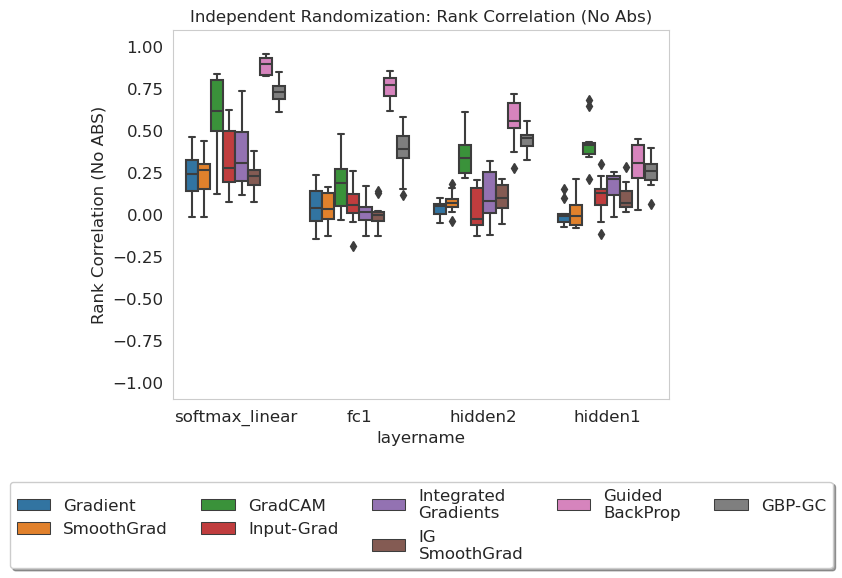

In [ ]:
dd=pd.melt(df,id_vars=['layername'],value_vars=first_methods,var_name='Saliency\nMethods')
ax = sns.boxplot(x='layername',y='value',data=dd,hue='Saliency\nMethods', order=layer_order)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("Rank Correlation (No ABS)")
ax.set_ylim([-1.1, 1.1])
ax.set_title("Independent Randomization: Rank Correlation (No Abs)")
plt.show()